In [9]:
from pathlib import Path 
import os
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import torch
import cv2
from ultralytics import YOLO
import glob
from PIL import Image
import numpy as np

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
data = "../data/data.yaml"


In [12]:
train_path = "../data/train"
val_path = "../data/valid"
test_path = "../data/test"

train_images = train_path + "/images"
val_images = val_path + "/images"
test_images = test_path + "/images"

train_labels = train_path + "/labels"
val_labels = val_path + "/labels"
test_labels = test_path + "/labels"




In [13]:
classes = ['fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']
num_classes = len(classes)
idx_to_class = {i : k for i,k in enumerate(classes)}
class_to_idx = {k: i for i, k in idx_to_class.items()}


In [14]:
class_to_idx

{'fish': 0,
 'jellyfish': 1,
 'penguin': 2,
 'puffin': 3,
 'shark': 4,
 'starfish': 5,
 'stingray': 6}

In [15]:
class_to_idx

{'fish': 0,
 'jellyfish': 1,
 'penguin': 2,
 'puffin': 3,
 'shark': 4,
 'starfish': 5,
 'stingray': 6}

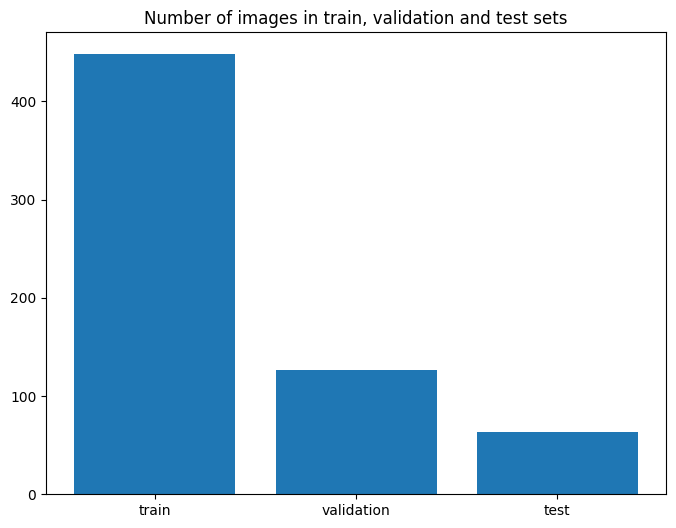

In [16]:
def plot_data(data: dict, title : str):
    plt.figure(figsize = (8,6))
    plt.bar(data.keys(), data.values())
    plt.title("Number of images in train, validation and test sets")
    plt.show()
    
def get_num_images(path):
    return len(os.listdir(path))

plot_data(data = {'train': get_num_images(train_images), "validation" : get_num_images(val_images), "test" : get_num_images(test_images)}, title = 
          "Number of images in train, test and val splits")  
    

In [17]:
def count_obj_per_split(image_dir, label_dir):
    object_count = {}
    total_object_count = []
    img_files = sorted(os.listdir(image_dir))
    for file in img_files: 
        label_path = os.path.join(label_dir,  file[:-4] + ".txt")
        f = open(label_path, "r")
        lines = f.readlines()
        total_object_count.append(len(lines))
        for line in lines: 
            object_count[(idx_to_class[int(line.split()[0])])] = object_count.get(idx_to_class[int(line.split()[0])], 0) + 1
        f.close()
    return object_count, total_object_count    



In [18]:
object_counts_train, total_train_objects = count_obj_per_split(train_images, train_labels)
object_counts_val, total_val_objects = count_obj_per_split(val_images, val_labels)
object_counts_test, total_test_objects = count_obj_per_split(test_images, test_labels)

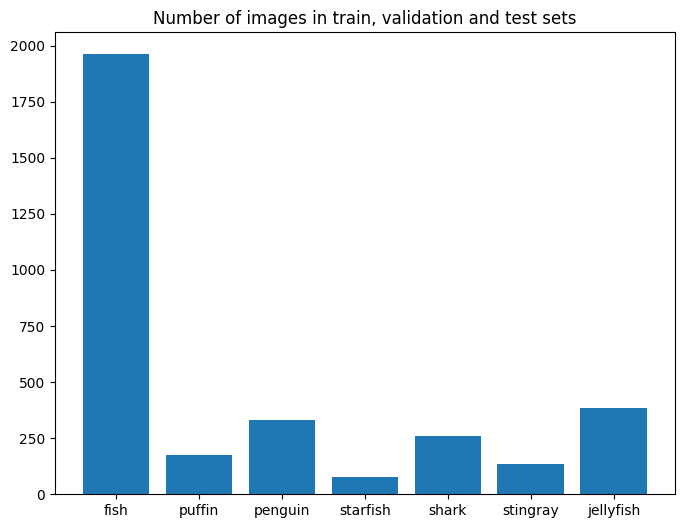

In [19]:
plot_data(object_counts_train, title = "Total instances of each class in training set")

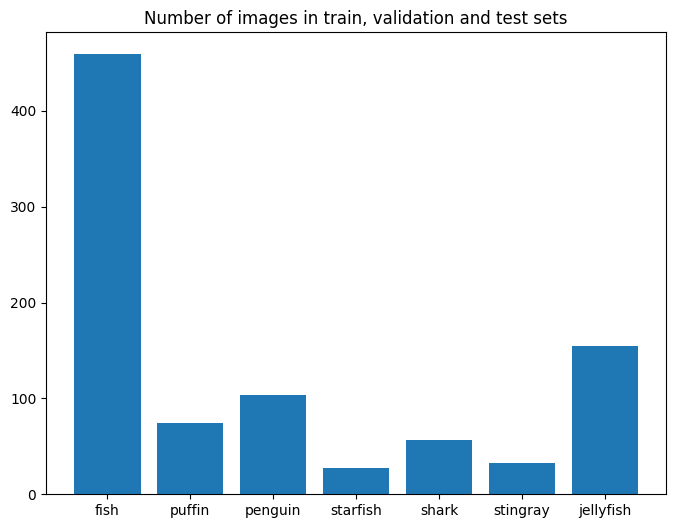

In [20]:
plot_data(object_counts_val, title = "Total instances of each class in validation set")

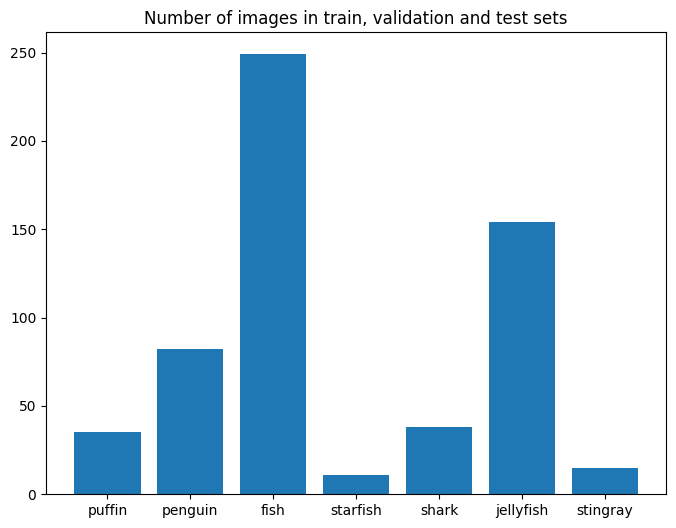

In [21]:
plot_data(object_counts_test, title = "Total instances of each class in test set")

Now we can consider the number of objects per image and visualise this in a histogram 

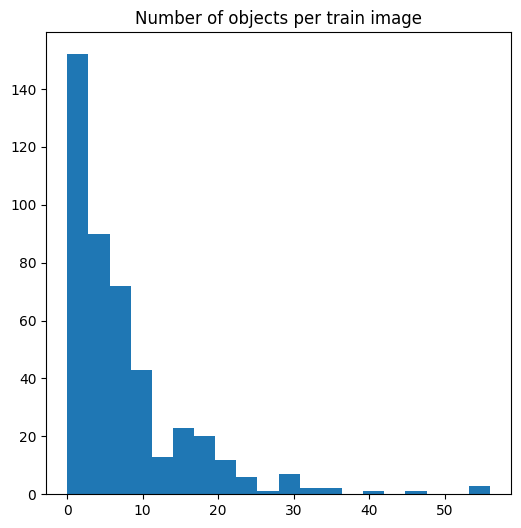

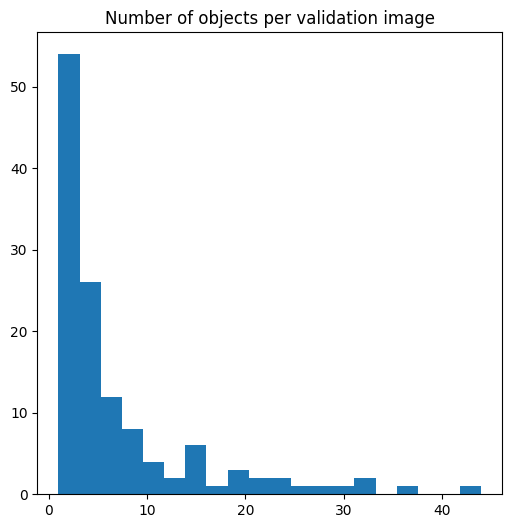

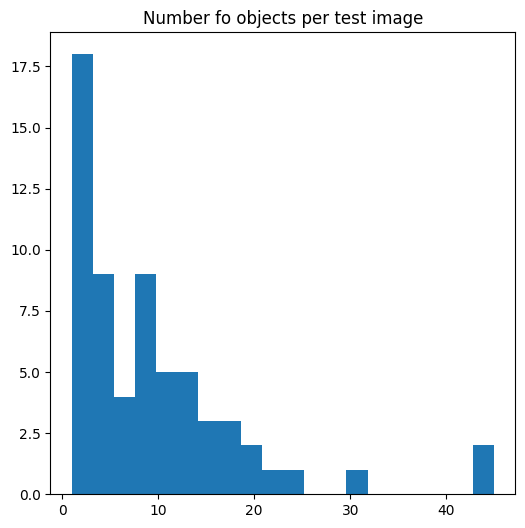

In [22]:
def plot_hist(x_var : list, title:str, bins: int = 20):
    plt.figure(figsize = (6,6))
    plt.hist(x = x_var, bins = bins)
    plt.title(title)
    plt.show()

plot_hist(total_train_objects, "Number of objects per train image")
plot_hist(total_val_objects, "Number of objects per validation image")
plot_hist(total_test_objects, "Number fo objects per test image")

Now,we can also visualise the bounding box sizes on average in the training, test and validation sets. 

In [23]:
def bounding_box_sizes(image_dir, label_dir):
    sizes = []
    image_files = sorted(os.listdir(image_dir))
    for image in image_files:
        label_path = os.path.join(label_dir, image[:-4] + ".txt")
        f = open(label_path, "r")
        lines = f.readlines()
        for line in lines: 
            sizes.append(float(line.split()[3]) * float(line.split()[4]))
        f.close()

    return sizes    

In [24]:
train_sizes = bounding_box_sizes(train_images, train_labels)
val_sizes = bounding_box_sizes(val_images, val_labels)
test_sizes = bounding_box_sizes(test_images, test_labels)

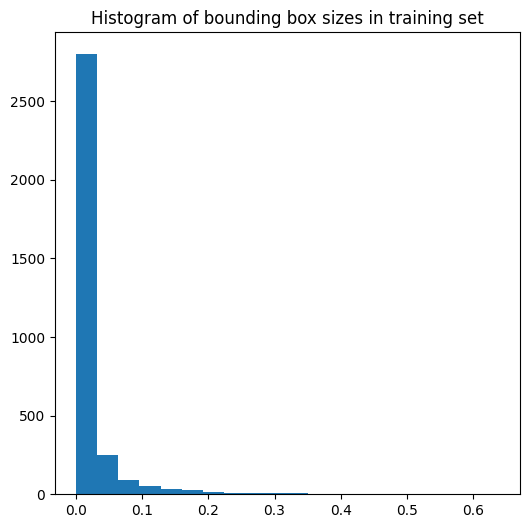

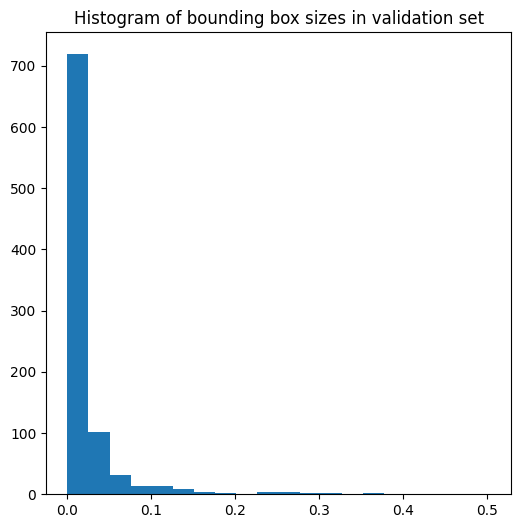

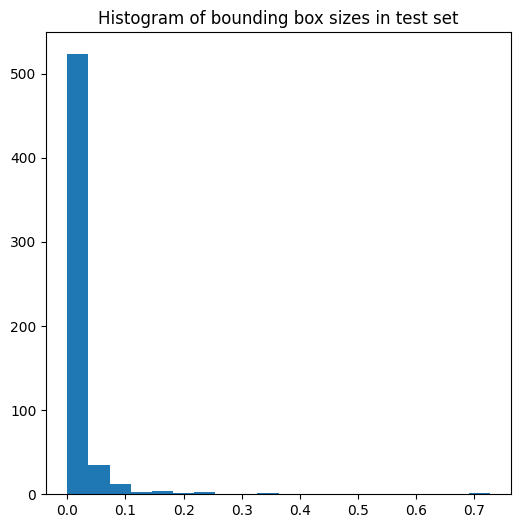

In [25]:
plot_hist(train_sizes, title = "Histogram of bounding box sizes in training set")
plot_hist(val_sizes, "Histogram of bounding box sizes in validation set")
plot_hist(test_sizes, "Histogram of bounding box sizes in test set")

In [26]:
def images_with_bbox_annots(image_dir, label_dir):
    image_files = sorted(os.listdir(image_dir))

    sample_images = random.sample(image_files, 12)

    fig, axs = plt.subplots(4,3, figsize = (15,20))

    for i, image in enumerate(sample_images):
        image_path = os.path.join(image_dir, image)
        label_path = os.path.join(label_dir, image[:-4] + ".txt")
        f = open(label_path)

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        for line in f: 
            class_id, x_center, y_center, width, height = map(float, line.split())
            h, w, _ = image.shape
            x_min = int((x_center - width / 2) * w)
            y_min = int((y_center - height / 2) * h)
            x_max = int((x_center + width / 2) * w)
            y_max = int((y_center + height / 2) * h)

            cv2.rectangle(image, (x_min,y_min), (x_max, y_max), (255,0,0), 2)
            cv2.putText(image, idx_to_class[int(class_id)],
                        (x_min, y_min), cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale = 1, color = (255,255,255), thickness = 3)
        row = i // 3
        col = i % 3    
            
        axs[row, col].imshow(image)
        axs[row, col].axis("off")
    plt.show()    
        

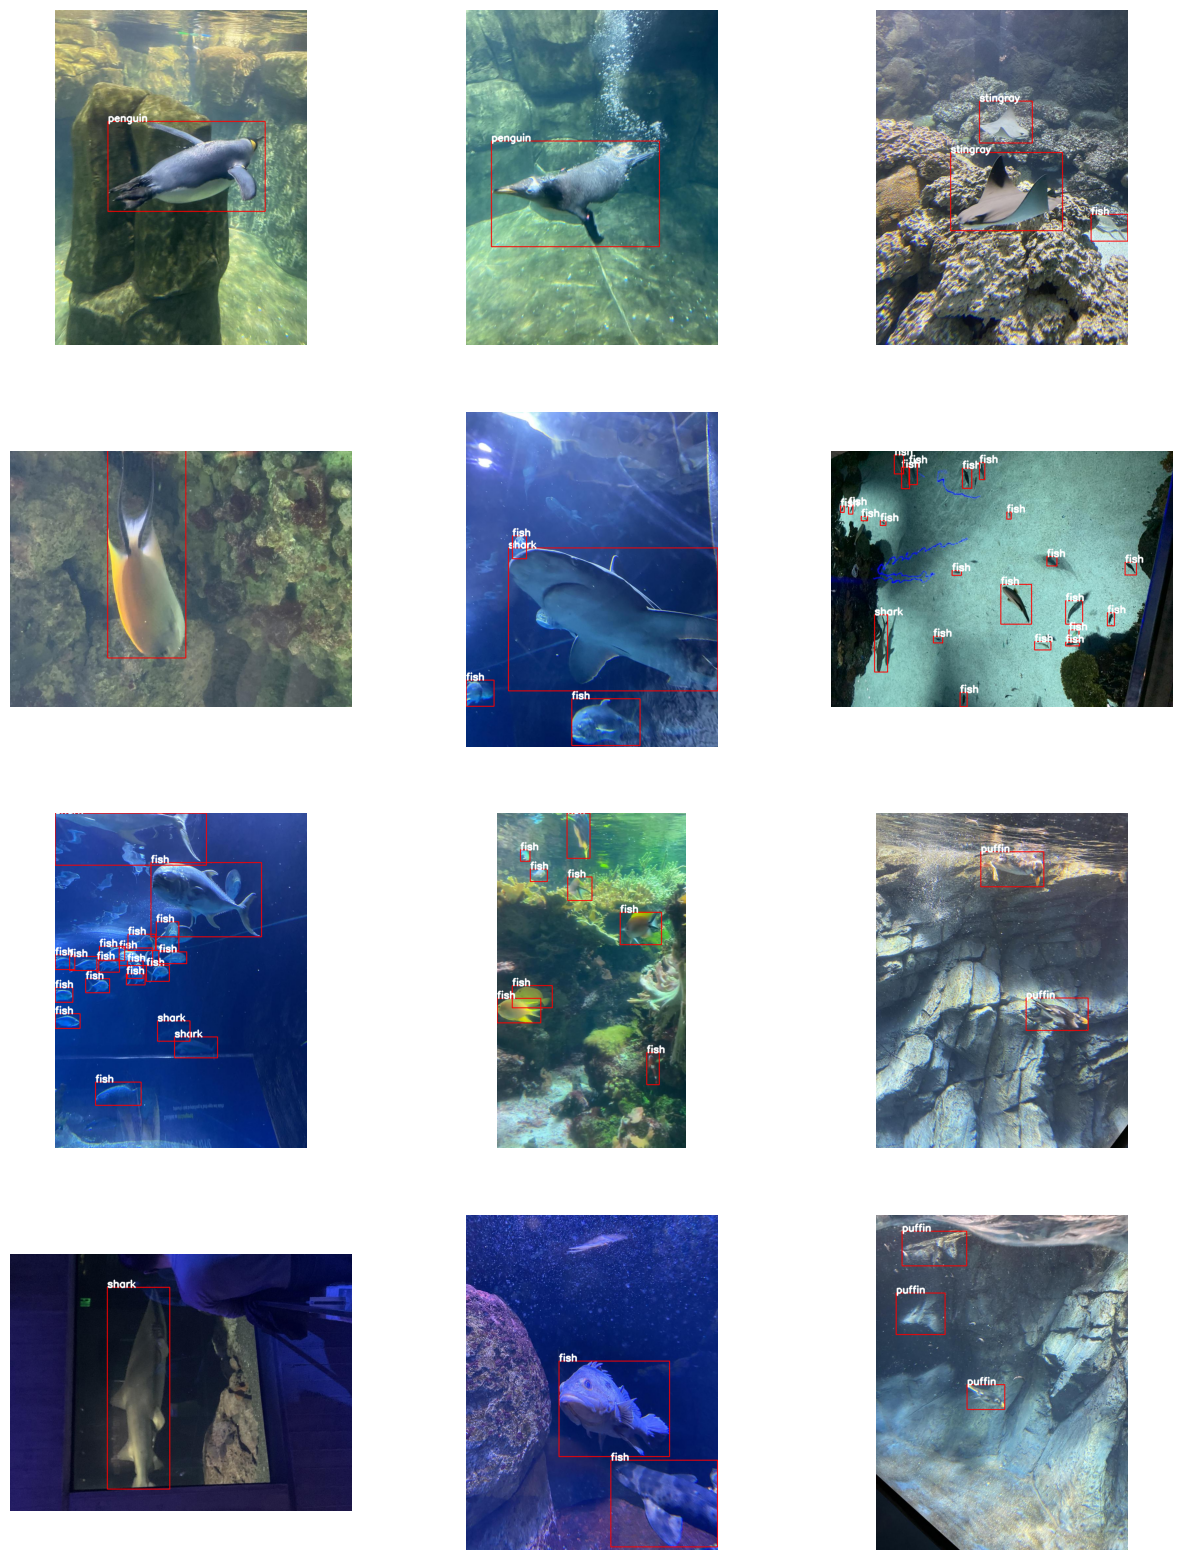

In [27]:
images_with_bbox_annots(train_images, train_labels)

Now it's time for preprocessing. This is done to make sure that the images are in the format expected by the RCNN models. First order of action is to resize the images. A function is defined which resizes images to (640, 640) if the images are square, and otherwise rescales the image while maintaining aspect ratio. 

Another very important feature to add when forming the dataloader is a custom collate function which tells the Dataloader how to combine multiple samples into a batch. Since the bounding boxes in each sample can be variable, it is important to create a custom collate function that groups them by element type instead of stacking them. 

## Modelling 
Now, when we delve into modelling, the model that is going to be used is the Faster R-CNN model. The Faster R-CNN model identifies objects in an image and draws bounding boxes around them, while at the same time also classifying what those objects are. It's inference consists of two phases of detection: 

- **1st Stage**: It first proposes regions in the image that might contain images and this is known as Region Proposal Network (RPN)
- **2nd Stage**: It uses these proposed regions to predict the class that the image belongs to and then simultaneously changes the bounding box to better match the object. 

The model that is going to be used  as the backbone is the ResNet 101

### Loss function

Before this however, the loss function has to be defined. While the most common loss function for a long time was IoU (Intersection over Union) which calculates the intersection of two bounding boxes over the union of the two bounding boxes. This is a fine metric but recent developments have seen a greater use of GIoU (Generalized Intersection over Union) which fixes one major issue of the IoU metric which is that when there is no intersection between bounding boxes, the IoU values are 0 which then leads to issues in backpropagation. In addition to this, if there are two cases where there is no intersection between bounding boxes but in one the second bounding box is closer than in the other case, then it would be nice to provide that information to the model. However, in the case of IoU, both cases will be 0. This is addressed in the GIoU loss function, which is defined as, 

$$\text{GIoU} = \text{IoU} - \frac{\text{Area of } C - \text{Area of } (A \cup B)}{\text{Area of } C}$$

Where:
- $A$ = bounding box 1
- $B$ = bounding box 2
- $C$ = smallest enclosing box containing both $A$ and $B$
- $\text{IoU} = \frac{|A \cap B|}{|A \cup B|}$

Thus, in this case, when there is no intersection between two bounding boxes, the GIoU value actually becomes negative which addresses both of the major issues with IoU. The GIoU values range from -1 to 1 where +1 indicates perfect overlap between both bounding boxes and -1 indicates that there is no overlap between the boxes and at the same time the two bounding boxes are very far apart. 

In [28]:
model = YOLO("yolo26n.pt")

In [31]:
results = model.train(data = data, epochs = 10, batch = 8, device = device)

Ultralytics 8.4.10 🚀 Python-3.12.4 torch-2.9.1 CPU (Apple M3)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo26n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretra